## plot the mcmc sampling result

In [5]:

import os, sys
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from getdist import plots
from desilike.samples import plotting, Chain, Profiles
from desilike.parameter import ParameterCollection
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [6]:
sys.path.append('../')
from helper import PLANCK_COSMOLOGY, REDSHIFT_BIN_LSS
from plotting_tools import get_mcmc_plot_args, COLOR_TRACERS, get_namespace, plot_observable, plot_mcmc_walkers
from fitting_tools import load_blinded_data_pip, load_bins, get_template, get_theory, get_measurement_fn, get_observable_likelihood
%load_ext autoreload
%autoreload 2

# RESULT_DIR = '/pscratch/sd/s/shengyu/Y3/results/test/full-shape'
RESULT_DIR = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results'
SAVE_DIR = '/global/homes/s/shengyu/Y3/blinded_data_splits/main/results'
save_fig = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# fit settings
fit       = 'FM' # 'FM' 'SF'
option  = '' # '_wq_prior' only for ShapeFit
# option = ''
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

tracers = ['BGS','LRG','ELG','QSO'] # 'BGS','LRG', 'ELG', 'QSO' 
weight_type = 'default_fkp'
regions = ["GCcomb", "NGC", "SGC"]
TRACER_BINS = [(tracer, zrange) for tracer, zranges in REDSHIFT_BIN_LSS.items()
               if tracer in tracers for zrange in zranges]

all_chains = {}
for tracer, zrange in TRACER_BINS:
    for region in regions:
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        chain_fn = (RESULT_DIR + f'/full-shape/mcmc/chain_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{option}.npy')
        print(f'[LOAD:] {chain_fn}')
        chain = Chain.load(chain_fn)
        all_chains[f'{tracer}_{zrange}_{region}'] = chain

[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_GCcomb_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_NGC_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_SGC_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_LRG_z0.4-0.6_GCcomb_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_LRG_z0.4-0.6_NGC_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/moc

## Plot the 1d constraints

/tmp/ipykernel_2079885/305911756.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


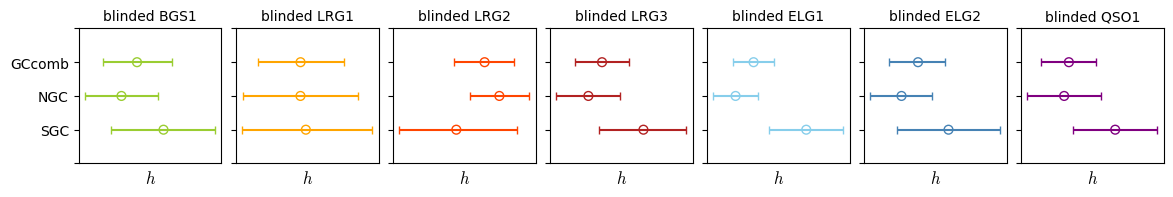

/tmp/ipykernel_2079885/305911756.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


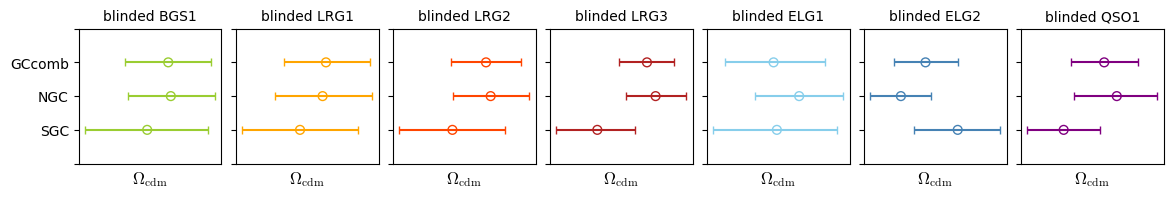

/tmp/ipykernel_2079885/305911756.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


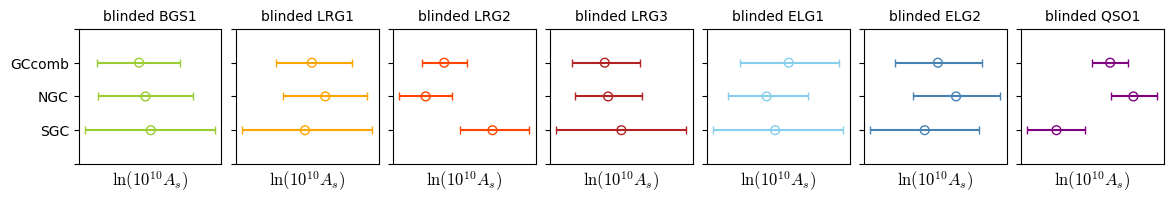

In [8]:
regions = ["GCcomb", "NGC", "SGC"]
for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    fig = plt.figure(figsize=(2*len(TRACER_BINS), 0.5*len(regions)))
    gs = gridspec.GridSpec(1, len(TRACER_BINS),  wspace=0.1, hspace=0.0, top=0.95, bottom=0.05)
    n_bins = len(TRACER_BINS)
    yticks = np.arange(len(regions)+2)
    for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        plt.rcParams['mathtext.fontset'] = 'cm' 
        ax = fig.add_subplot(gs[0, ind_col])
        tracer_label = get_namespace(tracer, zrange)
        ax.set_title(f"blinded {tracer_label}", fontsize=10)
        ax.set_yticks(yticks)
        if ind_col == 0:
            ax.set_yticklabels(['']+regions+[''], fontsize=10)
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(param_label, fontsize =12)
        color = COLOR_TRACERS[tracer_label]
        # plot the truth values
        # ax.axvline(mcmc_args['true_values'][param], color='k', linestyle='--', linewidth=1, alpha=0.8,)
        # plot the 1d constraint
        for y, region in enumerate(regions):
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            # horizontal guide line for the region
            ax.scatter(mean, y+1,  edgecolors=color, facecolors='none', s=40)
            ax.errorbar(mean, y+1, xerr=[[mean - q05], [q95 - mean]], color=color, capsize=3)
            ax.set_ylim([0,len(regions)+1])
        ax.invert_yaxis()
        ax.set_yticks(ax.get_yticks()[::-1])
        ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    plt.tight_layout()
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/1d_constraint_{fit}{option}_{param}_GCcompare.png', dpi=600, bbox_inches='tight')

## Summary Table (the difference)

In [56]:
df = pd.read_csv(SAVE_DIR+f"/tables/table_{fit}{option}fit_values.csv")

# Compute std
df["std"] = 0.5 * (df["q95"] - df["q05"])

tracer_labels = get_namespace(tracer, zrange)

df["value"] = df.apply(lambda r: f"{r['mean']:.3f} ± {r['std']:.3f}", axis=1)
# ---- Build pivot table ----
table = df.pivot_table(index=["param", "region"],   # Multi-index rows
                       columns="name",              # each tracer_bin becomes a column
                       values="value",
                       aggfunc="first")

# Sort rows by param order and region order
region_order = ["GCcomb", "NGC", "SGC"]
table = table.reindex(regions, level="region")
table = table.reindex(mcmc_args['params'], level="param")
table = table[['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']]

chi2_rows = (df.groupby(["region", "name"])["chi2"].first().unstack("name"))
chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")
chi2_rows.index = pd.MultiIndex.from_product([["chi2"], chi2_rows.index], names=["param", "region"],)

table = pd.concat([table, chi2_rows])

pd.set_option("display.width", 1000)      # very wide output
print(table)

name                    BGS1            LRG1            LRG2            LRG3            ELG1           ELG2            QSO1
param region                                                                                                               
qiso  GCcomb   0.980 ± 0.015   1.001 ± 0.014   0.969 ± 0.012   1.002 ± 0.009   0.995 ± 0.017  0.980 ± 0.010   1.002 ± 0.012
      NGC      0.992 ± 0.019   1.004 ± 0.017   0.967 ± 0.013   1.010 ± 0.011   1.006 ± 0.015  0.984 ± 0.010   1.009 ± 0.016
      SGC      1.017 ± 0.042   1.016 ± 0.024   1.011 ± 0.036   0.993 ± 0.016   0.976 ± 0.030  0.980 ± 0.018   0.994 ± 0.020
qap   GCcomb   1.017 ± 0.051   1.004 ± 0.045   1.012 ± 0.038   1.005 ± 0.028   1.050 ± 0.051  1.035 ± 0.031   0.976 ± 0.032
      NGC      1.025 ± 0.055   1.000 ± 0.055   1.033 ± 0.042   1.013 ± 0.032   1.066 ± 0.052  1.049 ± 0.037   0.961 ± 0.037
      SGC      1.274 ± 0.112   1.099 ± 0.093   1.102 ± 0.120   1.017 ± 0.052   1.073 ± 0.103  1.040 ± 0.063   0.997 ± 0.051
dm    GC

/tmp/ipykernel_447255/1017832788.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")


In [ ]:
import pandas as pd
fit       = 'SF' # 'FM' 'SF'
option  = '_wide_sp' # only for ShapeFit
df = pd.read_csv(SAVE_DIR + f"/tables/table_{fit}{option}fit_values.csv")

# Clean region labels just in case: strip spaces, newlines, etc.
df["region"] = df["region"].astype(str).str.strip()
df["std"] = 0.5 * (df["q95"] - df["q05"])

# ----- build baseline (GCcomb) -----
base = (
    df[df["region"] == "GCcomb"]
    [["param", "name", "mean", "std"]]
    .rename(columns={"mean": "mean_base", "std": "std_base"})
)

# ----- NGC and SGC only -----
others = df[df["region"].isin(["NGC", "SGC"])] \
    [["param", "region", "name", "mean"]]

# ----- merge to attach baseline -----
merged = others.merge(base, on=["param", "name"], how="left")
merged["diff"] = merged["mean"] - merged["mean_base"]
merged["abs_norm"] = (merged["mean"] - merged["mean_base"]).abs() / merged["std_base"]
merged["val_str"] = merged["abs_norm"].apply(lambda x: f"{x:.2f}")
# merged["val_str"] = merged.apply(
#     lambda r: f"{r['diff']:.3f} ± {r['std_base']:.3f}",
#     axis=1,
# )

# ----- pivot to table -----
table_diff = merged.pivot_table(
    index=["param", "region"],
    columns="name",
    values="val_str",
    aggfunc="first"
)

if fit == 'FM': 
    param_order = ["h", "omega_cdm", "logA"] 
    label_map = {
        "h":         r"$\Delta h $",
        "omega_cdm": r"$\Delta\Omega_{\mathrm{cdm}} $",
        "logA":      r"$\Delta \ln(10^{10}A_s) $",
    }
elif fit == 'SF':
    param_order = ["qiso", "qap", "dm", "df"] 
    label_map = {
        "qiso": r"$\Delta \alpha_{\mathrm{iso}} $",
        "qap":  r"$\Delta \alpha_{\mathrm{ap}} $",
        "dm":   r"$\Delta d_m  $",
        "df":   r"$\Delta d_f  a$",}

# order
chi2 = df.pivot_table(
    index="region",
    columns="name",
    values="chi2",
    aggfunc="first",
)
region_order = ["NGC", "SGC"]
col_order    = ['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']

table_diff = table_diff.reindex(param_order, level="param")
table_diff = table_diff.reindex(region_order, level="region")
table_diff = table_diff.reindex(columns=col_order)

table_diff.index = table_diff.index.set_levels(
    [label_map.get(p, p) for p in table_diff.index.levels[0]],
    level="param"
)

# order regions + tracers
chi2_region_order = ["GCcomb", "NGC", "SGC"]
chi2 = chi2.reindex(chi2_region_order)
chi2 = chi2.reindex(columns=col_order)

# format χ² (e.g. 1 decimal place)
chi2_str = chi2.applymap(lambda x: f"{x:.1f}")

# give χ² a MultiIndex to match (param, region)
chi2_str.index = pd.MultiIndex.from_product(
    [[r"$\chi^2$ \n dof = (72-13)"], chi2_str.index],
    names=["param", "region"],
)

# concat value table + chi2 block
table_full = pd.concat([table_diff, chi2_str])

print(table_full)

name                                    BGS1  LRG1  LRG2  LRG3  ELG1  ELG2  \
param                           region                                       
$\Delta \alpha_{\mathrm{iso}} $ NGC     0.80  0.30  0.23  0.84  0.70  0.36   
                                SGC     3.07  0.91  2.70  1.13  1.13  0.07   
$\Delta \alpha_{\mathrm{ap}} $  NGC     0.11  0.04  0.34  0.27  0.28  0.44   
                                SGC     0.97  1.86  0.84  0.53  0.04  0.09   
$\Delta d_m  $                  NGC     0.19  0.08  0.26  0.43  0.00  0.07   
                                SGC     3.57  1.76  2.82  0.94  1.26  1.47   
$\Delta d_f  a$                 NGC     0.25  0.42  0.89  0.18  0.06  0.32   
                                SGC     0.01  1.36  1.94  0.65  0.20  1.28   
$\chi^2$ \n dof = (72-13)       GCcomb  58.0  55.6  59.8  70.1  70.1  53.1   
                                NGC     50.3  68.1  54.3  64.1  66.9  58.1   
                                SGC     60.8  53.2  47.1  61.2  

/tmp/ipykernel_1320783/3930158795.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_str = chi2.applymap(lambda x: f"{x:.1f}")


## plot the best fit and clustering

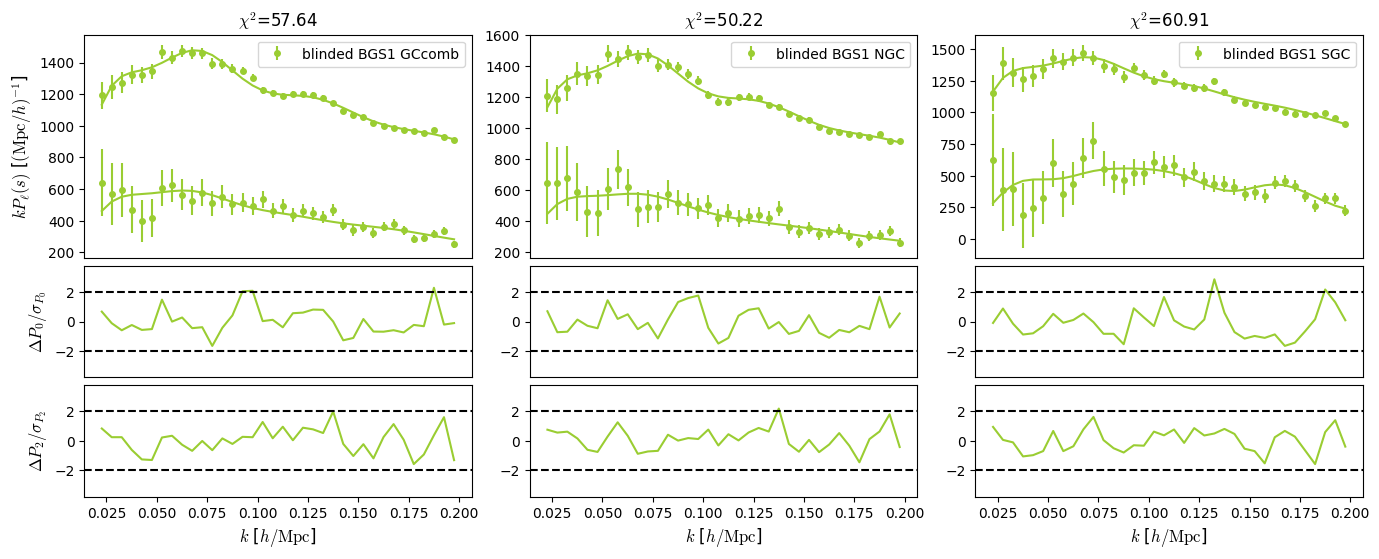

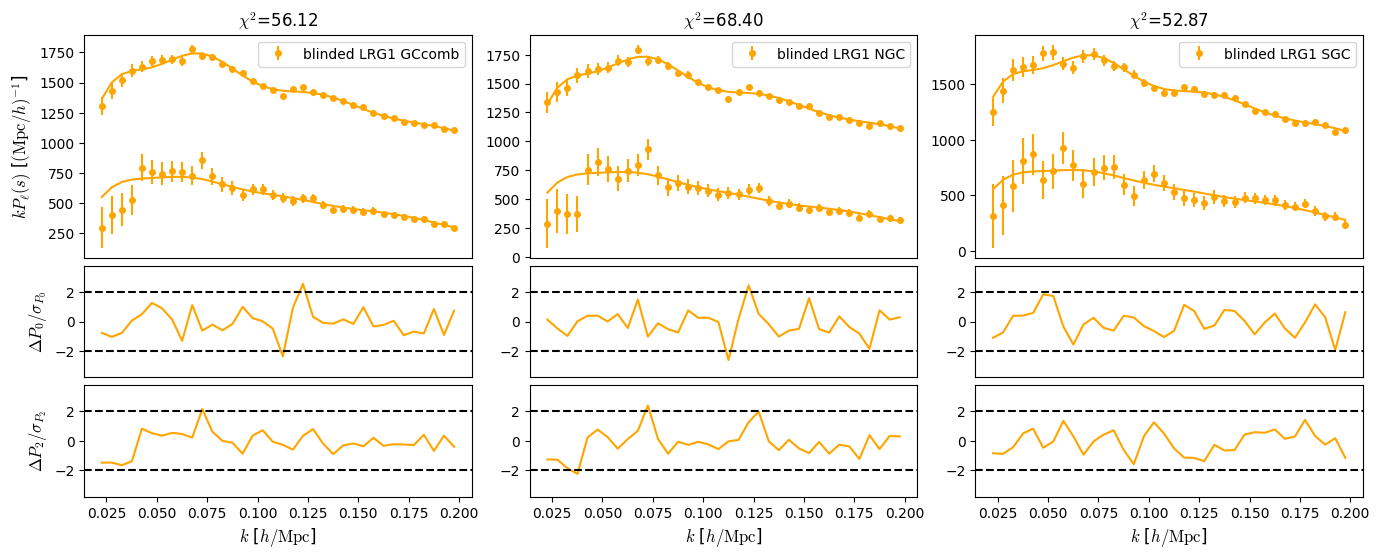

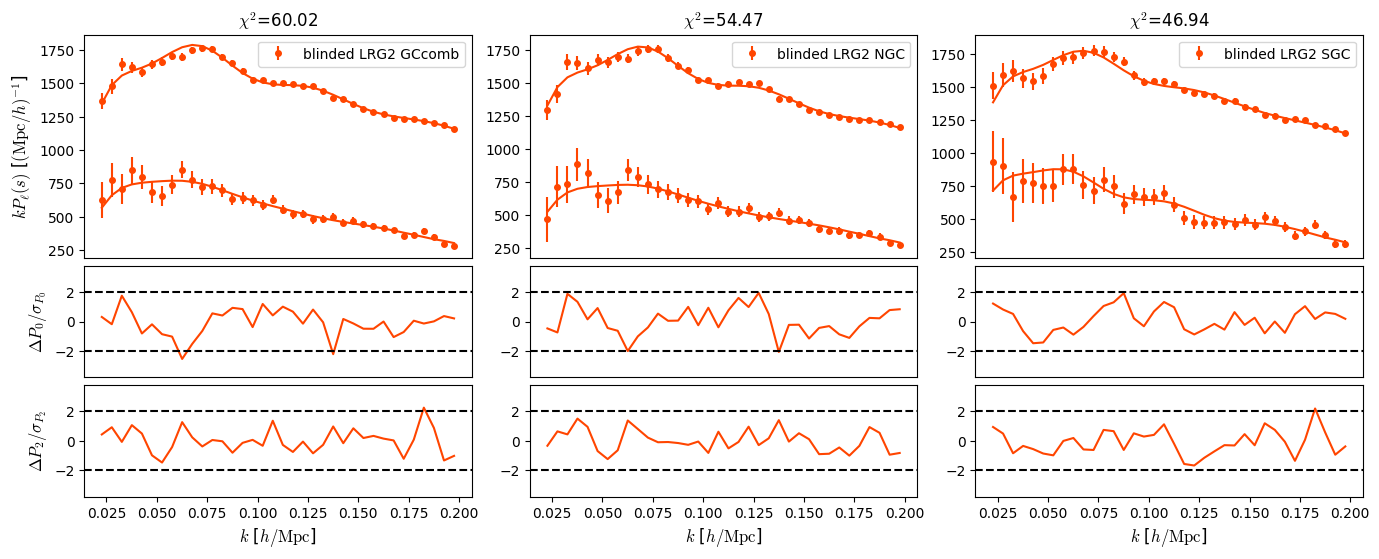

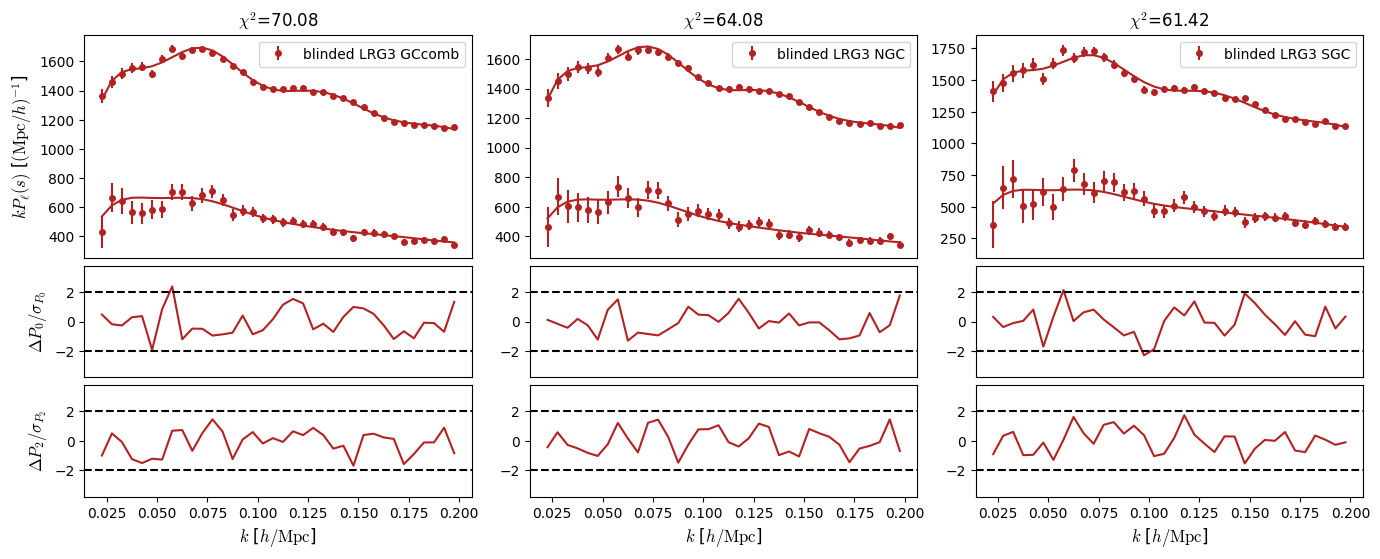

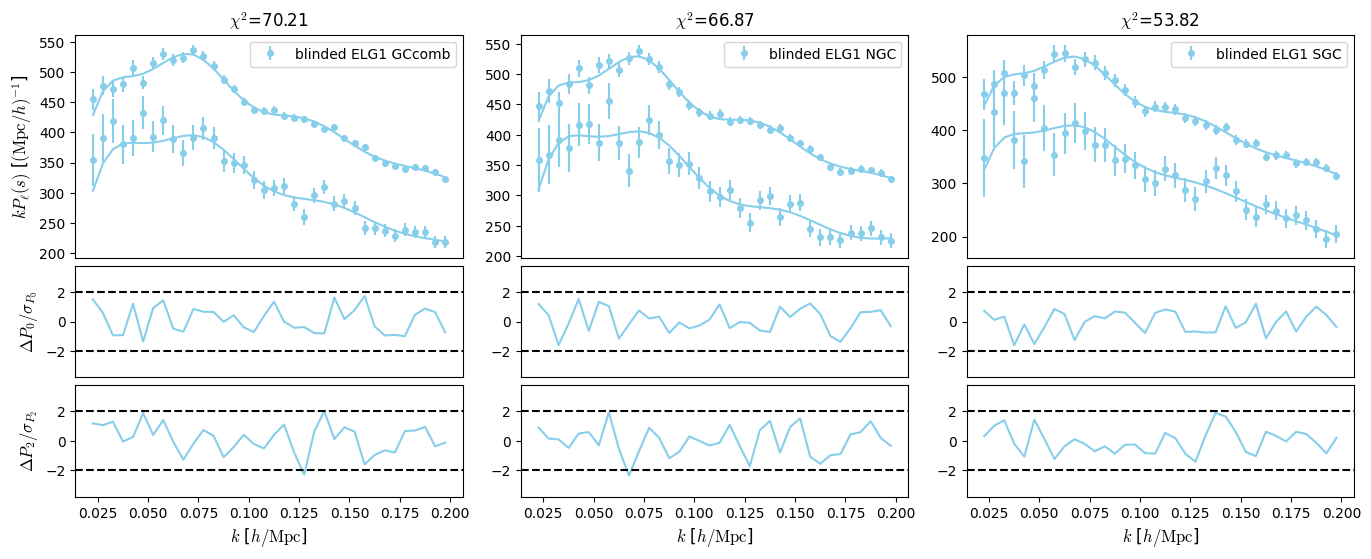

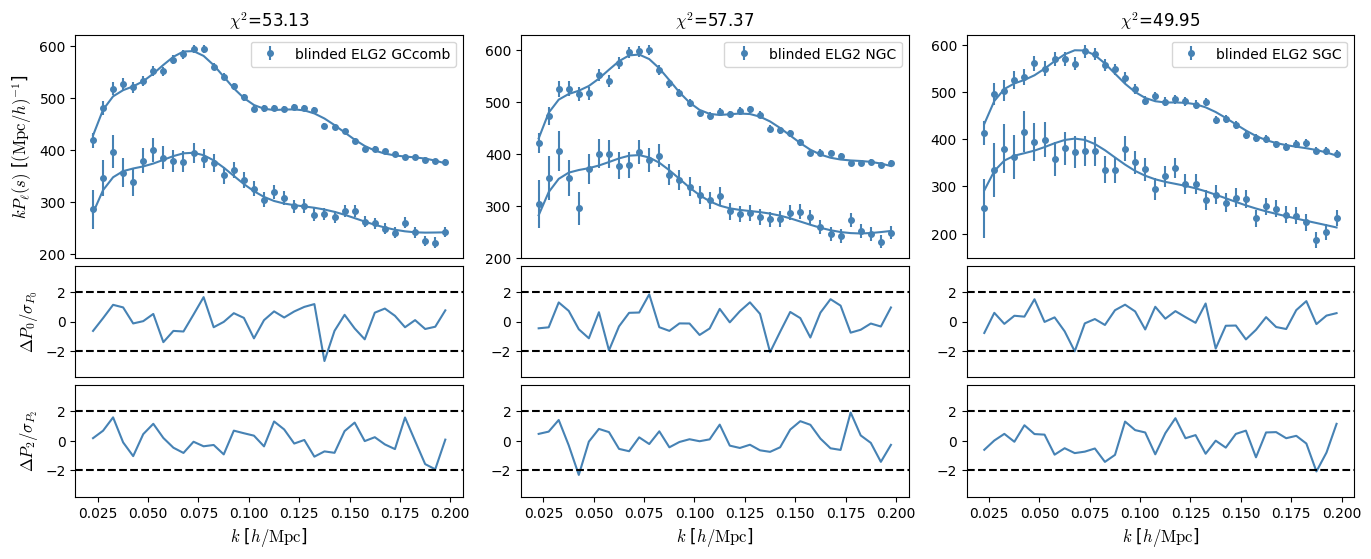

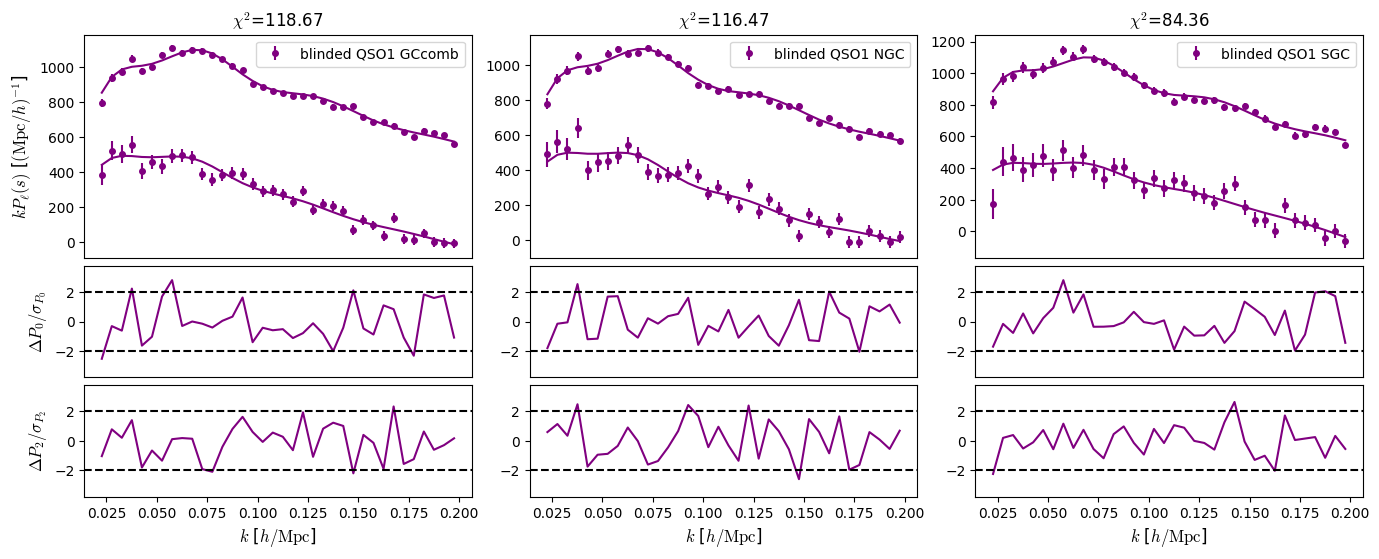

In [19]:
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')
for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    tracer_label = get_namespace(tracer, zrange)
    color = COLOR_TRACERS[tracer_label]

    regions = ['GCcomb','NGC','SGC']
    fig = plt.figure(figsize=(5.5 * len(regions), 6))
    gs = gridspec.GridSpec( 3, len(regions), wspace=0.15, hspace=0.05, height_ratios=[2, 1, 1])

    ax_top = []
    ax_bottom = [[], []]  # [row1, row2]
    for j in range(len(regions)):
        ax_top.append(plt.subplot(gs[0, j]))
        ax_bottom[0].append(plt.subplot(gs[1, j], sharex=ax_top[0]))
        ax_bottom[1].append(plt.subplot(gs[2, j], sharex=ax_top[0]))

    # for region in ['GCcomb','NGC','SGC']:
    for j,region in enumerate(regions):
        plot_kwargs = {'color':color, 'label':f'blinded {tracer_label} {region}'}
        data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
        emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}{option}.npy'
        fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
        (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
        chain0 = all_chains[f'{tracer}_{zrange}_{region}']
        chain = chain0.remove_burnin(remove_burnin)
        likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
        plot_observable(observable, ax_top[j], [ax_bottom[0][j], ax_bottom[1][j]], **plot_kwargs)
        ax_top[j].set_title(r'$\chi^2$'+f'={-2*likelihood():.2f}')
    for j in range(1, len(regions)):
        for ax in [ax_top[j], ax_bottom[0][j], ax_bottom[1][j]]:
             ax.set_ylabel('')
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/clustering_with_{fit}{option}bf_{tracer_label}_GCcompare.png', dpi=600, bbox_inches='tight')

## Posterior Plot

/tmp/ipykernel_1743414/66606570.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


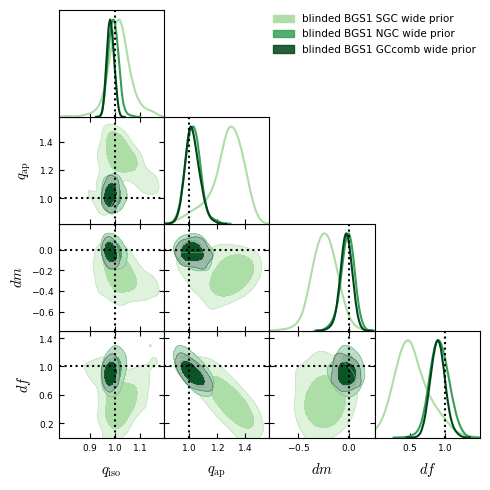

/tmp/ipykernel_1743414/66606570.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


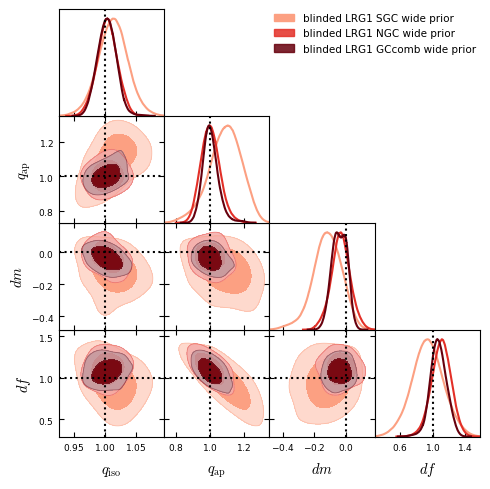

/tmp/ipykernel_1743414/66606570.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


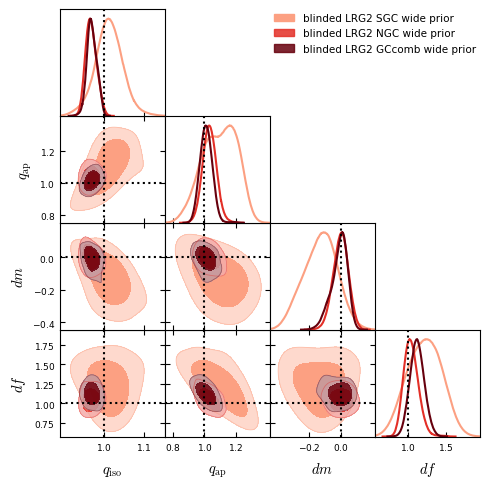

/tmp/ipykernel_1743414/66606570.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


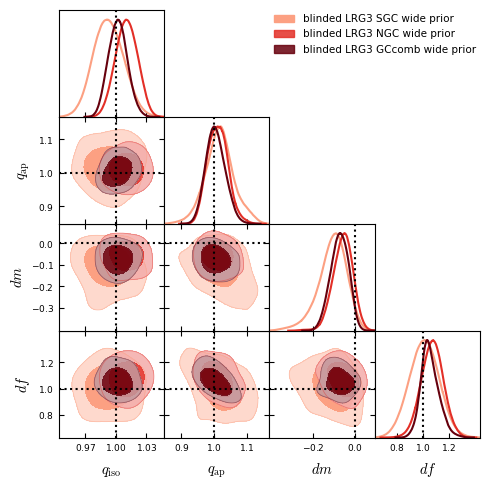

/tmp/ipykernel_1743414/66606570.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


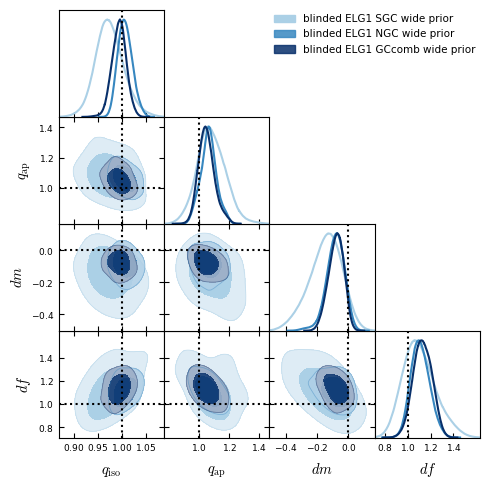

/tmp/ipykernel_1743414/66606570.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


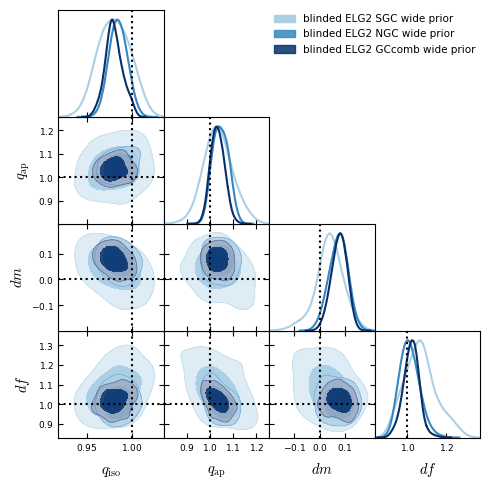

/tmp/ipykernel_1743414/66606570.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


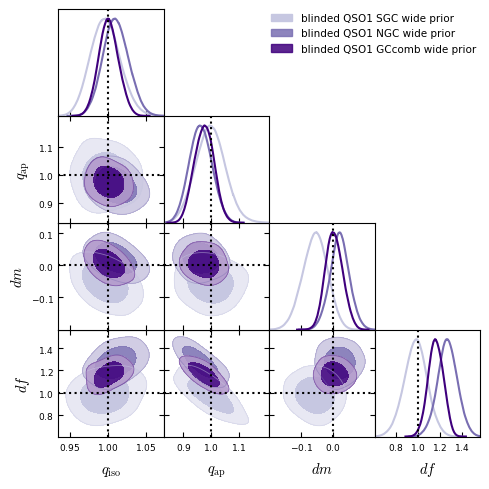

In [ ]:

# posterior corener plot
params = mcmc_args['params']

for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    chains = []
    colors = []
    labels = []
    # colormap = get_cmap('inferno')(np.linspace(0, 1, 6))
    map = 'vidirs'
    if tracer == 'BGS': 
        colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]
    if tracer == 'LRG':
        colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]
    if tracer == 'ELG': 
        colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]
    if tracer == 'QSO': 
        colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]
    for itask, region in enumerate(['SGC', 'NGC', 'GCcomb']):
        param_value = []
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)
        chain_fn = RESULT_DIR +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{option}.npy'
        chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
        # chain = all_chains[f'{tracer}_{zrange}_{region}']
        chains.append(chain)
        colors.append(tuple(colormap[itask+1]))
        labels.append(f'blinded {tracer_label} {region} wide prior' if option == '_wq_prior' else f'blinded {tracer_label} {region}')
        # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
    g = plots.get_subplot_plotter()
    g.settings.fig_width_inch= 5
    g.settings.legend_fontsize = 12
    g.settings.axes_labelsize = 15
    g.settings.figure_legend_frame = False
    plotting.plot_triangle(chains, 
                            params = params,
                            legend_labels = labels, legend_loc= 'upper right',
                            contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                            smoothed=True, show=False, filled = [True,True,True,True], g=g
                            )
    true_values = mcmc_args['true_values']
    for i, pi in enumerate(params):
        for j, pj in enumerate(params[:i+1]):
            ax = g.subplots[i, j]
            ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
            if i != j:
                ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
        g.fig.savefig(SAVE_DIR+f'/plots/corner_{fit}{option}_{tracer_label}_GCcompare', dpi=600, bbox_inches='tight')
    plt.show()

## Appendix save the fitting table

In [52]:
import pandas as pd
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')

regions = ["GCcomb", "NGC", "SGC"]
rows = []

for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    for tracer, zrange in TRACER_BINS:
        # match the naming you used for the chains
        raw_tracer = tracer
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)  # this will be your tracer_bin column name
        for region in regions:
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
            emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}{option}.npy'
            fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
            (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
            chi2 = -2*likelihood()
            # store raw numbers
            rows.append({"name": tracer_label, "region": region,
                        "param": param, "param_label": param_label,
                         "chi2": chi2, "mean": mean, "q05": q05, "q95": q95, })

df = pd.DataFrame(rows)

df
df.to_csv(f"../results/tables/table_{fit}{option}fit_values.csv", index=False)

/tmp/ipykernel_447255/3143697603.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


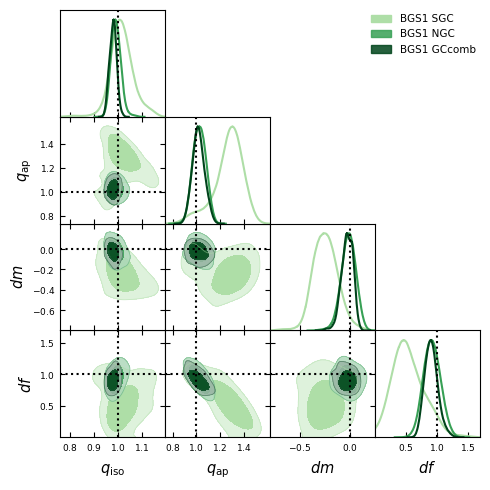

In [6]:
# posterior corener plot
# fit settings
fit       = 'SF'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

params = mcmc_args['params']
option = '_wide_sp_prior'
for ind_col, (tracer, zrange) in enumerate([('BGS', (0.1,0.4))]):
    chains = []
    colors = []
    labels = []
    # colormap = get_cmap('inferno')(np.linspace(0, 1, 6))
    map = 'vidirs'
    if tracer == 'BGS': 
        colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]
    if tracer == 'LRG':
        colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]
    if tracer == 'ELG': 
        colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]
    if tracer == 'QSO': 
        colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]
    for itask, region in enumerate(['SGC', 'NGC', 'GCcomb']):
        param_value = []
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)
        dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/test'
        chain_fn = dir +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_default_fkp{option}.npy'
        chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
        chains.append(chain)
        colors.append(tuple(colormap[itask+1]))
        labels.append(f'{tracer_label} {region}')
        # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
    g = plots.get_subplot_plotter()
    g.settings.fig_width_inch= 5
    g.settings.legend_fontsize = 12
    g.settings.axes_labelsize = 15
    g.settings.figure_legend_frame = False
    plotting.plot_triangle(chains, 
                            params = params,
                            legend_labels = labels, legend_loc= 'upper right',
                            contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                            smoothed=True, show=False, filled = [True,True,True,True], g=g
                            )
    true_values = mcmc_args['true_values']
    for i, pi in enumerate(params):
        for j, pj in enumerate(params[:i+1]):
            ax = g.subplots[i, j]
            ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
            if i != j:
                ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
        g.fig.savefig(SAVE_DIR+f'/plots/corner_{fit}_{tracer_label}_GCcompare', dpi=300, bbox_inches='tight')
    plt.show()

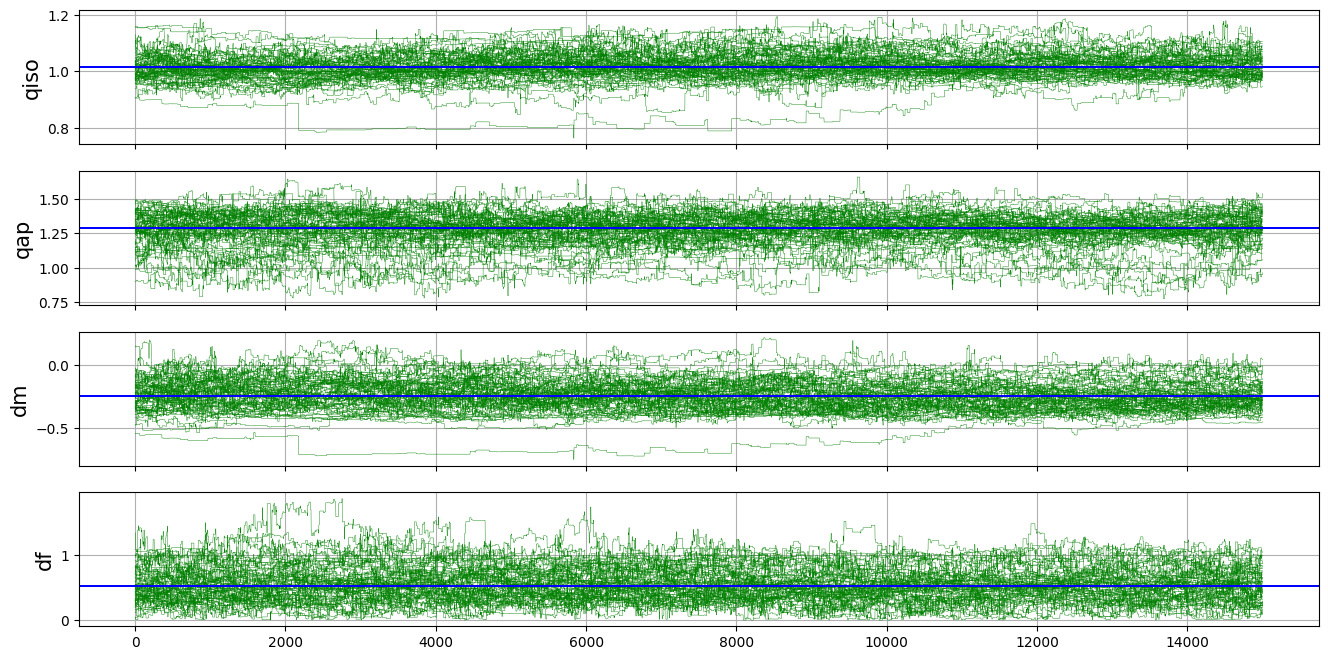

In [4]:
option = '_wide_sp_prior'
dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/test'
chain_fn = dir +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_SGC_default_fkp{option}.npy'
chain = Chain.load(chain_fn).remove_burnin(remove_burnin)
plot_mcmc_walkers(chain, params = mcmc_args['params'], nwalkers=64)

In [9]:
TRACER_BINS[:1]

[('BGS', (0.1, 0.4))]